## 0. Citation

- Research, Fractal AI. 2022. “Guide to Build Faster RCNN in PyTorch.” Medium (blog). May 19, 2022. https://medium.com/@fractal.ai/guide-to-build-faster-rcnn-in-pytorch-42d47cb0ecd3.
- Tien-Lung Sun, dir. 2020. How FasterRCNN Works and Step-by-Step PyTorch Implementation. https://www.youtube.com/watch?v=4yOcsWg-7g8.


## 1. Library Imports


In [1]:

%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
from torch import nn
import torchvision as tv
from torchvision import tv_tensors
from torchvision.io import read_image
from utils import image_visualizations as iv
from utils import dataset
from torchvision.utils import draw_bounding_boxes
from torchinfo import summary
from torchvision.transforms import v2
from typing import List
from utils import anchors
device = "cuda" if torch.cuda.is_available() else "cpu"

## 2. Loading an image

- We load a simple Pedestrian Dataset which consists of Pedestrains and Corresponding Masks
- From the masks we generate bboxes


In [2]:
image = read_image("../data/PennFudanPed/PNGImages/FudanPed00046.png")
mask = read_image("../data/PennFudanPed/PedMasks/FudanPed00046_mask.png")

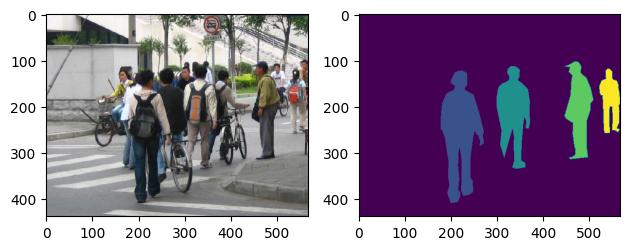

In [3]:
image_mask_pair = [image, mask]
figsize = (10, 8)
iv.plot(image_mask_pair)

In [4]:
root = "../data/PennFudanPed"
image_dir = "PNGImages"
mask_dir = "PedMasks"
ds = dataset.Masks2BboxDs(
    root,
    image_dir,
    mask_dir,
    transforms=v2.Resize(
        (800, 800), interpolation=v2.functional.InterpolationMode.BICUBIC
    ),
)
len(ds)

170

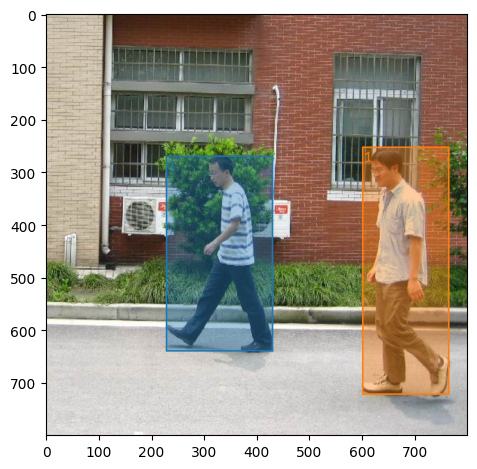

In [5]:
image, target = ds[0]
masks = target["masks"]
labels = target["labels"]
bboxes = target["boxes"]

colors = [mcolors.rgb2hex(plt.get_cmap("tab10")(i)) for i in range(len(masks))]
font = "/usr/share/fonts/truetype/ubuntu/UbuntuMono-R.ttf"
bbox_image = draw_bounding_boxes(
    image,
    bboxes,
    labels,
    font=font,
    width=3,
    fill=True,
    font_size=30,
    colors=colors,
)
iv.plot(bbox_image)

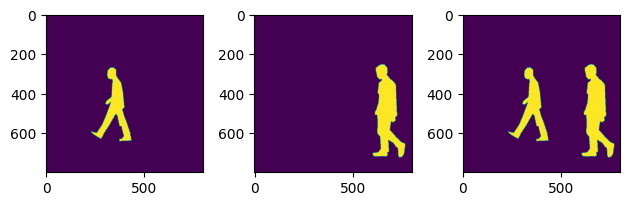

In [6]:
combined_mask = torch.bitwise_or(*masks)
iv.plot([*masks, combined_mask])

## 3. Feature Extraction


- We would like to have features to generate anchors
- To generate features we use VGG16


In [7]:
model = tv.models.vgg16(weights=True).to(device)
summary(model, (1, 3, 800, 800))

/home/yuvidh/work/Projects/Computer_Vision/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1000]                 --
├─Sequential: 1-1                        [1, 512, 25, 25]          --
│    └─Conv2d: 2-1                       [1, 64, 800, 800]         1,792
│    └─ReLU: 2-2                         [1, 64, 800, 800]         --
│    └─Conv2d: 2-3                       [1, 64, 800, 800]         36,928
│    └─ReLU: 2-4                         [1, 64, 800, 800]         --
│    └─MaxPool2d: 2-5                    [1, 64, 400, 400]         --
│    └─Conv2d: 2-6                       [1, 128, 400, 400]        73,856
│    └─ReLU: 2-7                         [1, 128, 400, 400]        --
│    └─Conv2d: 2-8                       [1, 128, 400, 400]        147,584
│    └─ReLU: 2-9                         [1, 128, 400, 400]        --
│    └─MaxPool2d: 2-10                   [1, 128, 200, 200]        --
│    └─Conv2d: 2-11                      [1, 256, 200, 200]        29

In [8]:
model_features = list(model.features)
print(len(model_features))

31


In [9]:
### Collecting layers with output feature map size i.e both width and height of feature map are < 50 (50 is used in the paper)
dummy_img = torch.zeros(
    (1, 3, 800, 800)
).float()  # test image array [1, 3, 800, 800]
print(dummy_img.shape)

req_features = []
k = dummy_img.clone().to(device)
for i in model_features:
    k = i(k)
    if k.size()[2] < 800 // 16:  # 800/16=50
        break
    req_features.append(i)
    out_channels = k.size()[1]

print(len(req_features))  # 30 # Total features taken are
print(out_channels)  # 512 # Depth of the layer's op

torch.Size([1, 3, 800, 800])
30
512


In [10]:
req_features

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1

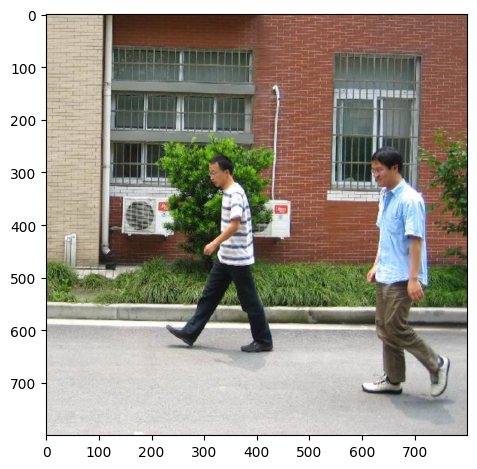

In [11]:
iv.plot(image)

In [12]:
# Converting the list into a Sequential module
faster_rcnn_fe_extractor = nn.Sequential(*req_features).to(device)
image_copy = image.float().to(device).unsqueeze(0)
# Running the feature extractor on our image
feature_map = faster_rcnn_fe_extractor(image_copy)

In [13]:
imgArray = feature_map.data.cpu().squeeze(0)

In [14]:
imgArray[0].shape

torch.Size([50, 50])

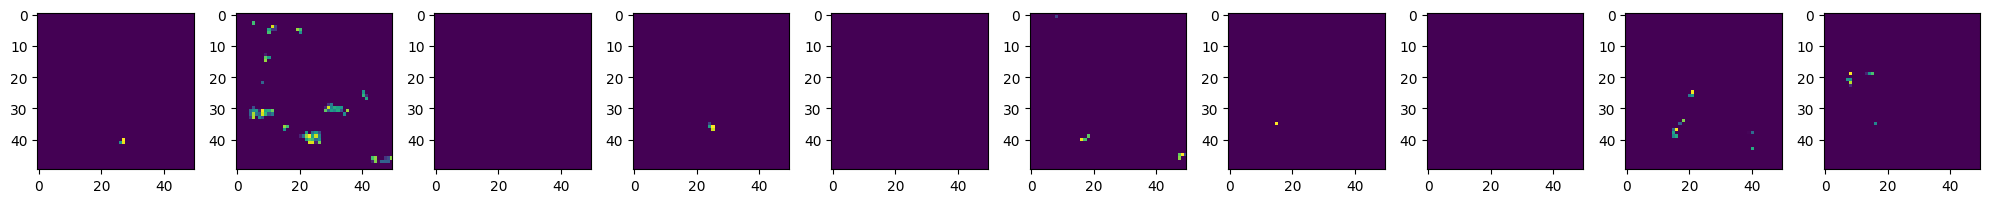

In [15]:
num_plots = 10
iv.plot(
    [imgArray[i] for i in range(num_plots)],
    subplots_kwargs={"figsize": (20, 20)},
    subplot_adjust_kwargs={"hspace": 0, "wspace": 0.3},
)

## 4. Generating Anchor Bboxes


- Once we have got the feature map, in our case of size (512,50,50)
- We need Anchors, to generate Anchor Bboxes.
- Anchors are nothing but every pixel of the feature map (So we have 2500 anchors)
- These pixels are representation of a patch in the original image
- Another interesting bit is since we used VGG16 from beginning to end of final conv stack of VGG, we got 50x50xC feature map, from 800x800x3 image.
  - This conveys one pixel on the map corresponds to 16 by 16 patch on the original image
  - So if you move pixel wise one by one on the feature map, one can imagine a patch of size 16x16 moving correspondingly on the image
  - For this patch on image we will take it's center
- Now to generate Anchor Boxes, we map the anchor points from feature map to the original image
  - On the original image we generate various size bboxes
  - Precisely, for each anchor at the **center** we generate 9 bboxes, each in 3 ratios (small, medium & large) and in 3 shapes (square(surrounding the anchor), 2 rectangles perpendicular to each other)
- Bboxes are generated in following manner:
  - Consider a 16 by 16 patch on original image, calculate it's center
  - This center can be considered as a back-representation of anchor we see on the feature map
  - On this center we generate 9 bboxes as mentioned above, thus for 250 centres 9 bboxes leading to 22500 bboxes


In [16]:
# Example usage
feature_map_size = 50  # Size of the feature map (example value)
patch_size = (
    800 // feature_map_size
)  # The stride of the sliding window or feature map stride
aspect_ratios = [0.5, 1, 2]
shapes = [8, 16, 32]

anchor_bboxes = anchors.generate_anchors(
    feature_map_size, patch_size, aspect_ratios, shapes
)
print(anchor_bboxes.shape)  # (22500, 4)

(22500, 4)


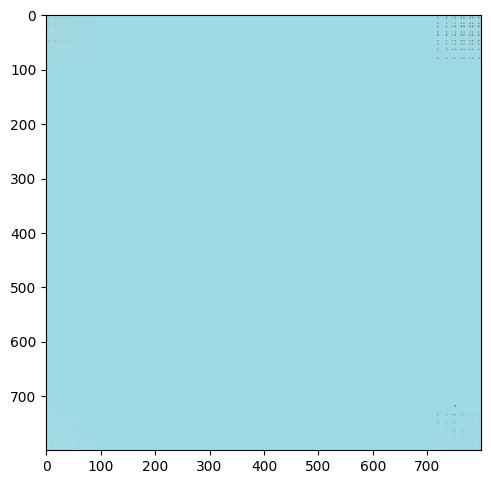

In [17]:
torch_bboxes = tv_tensors.BoundingBoxes(
    anchor_bboxes, format="XYXY", canvas_size=v2.functional.get_size(image)
)

colors = [
    mcolors.rgb2hex(plt.get_cmap("tab20")(i)) for i in range(len(torch_bboxes))
]
font = "/usr/share/fonts/truetype/ubuntu/UbuntuMono-R.ttf"
bbox_image = draw_bounding_boxes(
    image,
    torch_bboxes,
    font=font,
    width=3,
    fill=False,
    font_size=30,
    colors=colors,
)
iv.plot(bbox_image, subplots_kwargs={"figsize": (5, 5)})

### Viewing a single anchor's Bboxes


In [18]:
x_coor, y_coor = 400, 400
# Subtracting 8 is necessary as we generated bboxes for center of
# patches and x_coor and y_coor are the bottomright coordinates of a patch
center_anchors = anchors.get_anchors_for_coordinate(
    anchor_bboxes, coordinate=(x_coor - 8, y_coor - 8)
)

/home/yuvidh/work/Projects/Computer_Vision/venv/lib/python3.12/site-packages/torchvision/tv_tensors/_tv_tensor.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.as_tensor(data, dtype=dtype, device=device).requires_grad_(requires_grad)


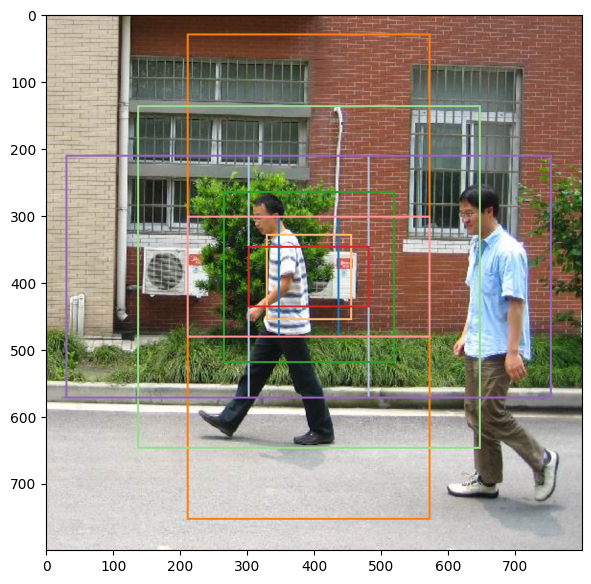

In [19]:
torch_bboxes = tv_tensors.BoundingBoxes(
    center_anchors, format="XYXY", canvas_size=v2.functional.get_size(image)
)

colors = [
    mcolors.rgb2hex(plt.get_cmap("tab20")(i)) for i in range(len(torch_bboxes))
]
font = "/usr/share/fonts/truetype/ubuntu/UbuntuMono-R.ttf"
bbox_image = draw_bounding_boxes(
    image,
    torch_bboxes,
    font=font,
    width=3,
    fill=False,
    font_size=30,
    colors=colors,
)
iv.plot(bbox_image, subplots_kwargs={"figsize": (6, 6)})

### Validating the Anchor Bboxes

- We remove the bboxes who go out of the condition i.e. xmin, ymin being less than 0 and xmax,ymax being > 800


In [20]:
index_inside = np.where(
    (anchor_bboxes[:, 0] >= 0)
    & (anchor_bboxes[:, 1] >= 0)
    & (anchor_bboxes[:, 2] <= 800)
    & (anchor_bboxes[:, 3] <= 800)
)[0]
filtered_bboxes = anchor_bboxes[index_inside]

# filtered_bboxes = []
# for bbox in anchor_bboxes:
#     xmin, ymin, xmax, ymax = bbox
#     if xmin >= 0 and ymin >= 0 and xmax <= 800 and ymax <= 800:
#         filtered_bboxes.append(bbox)
# print(len(filtered_bboxes))

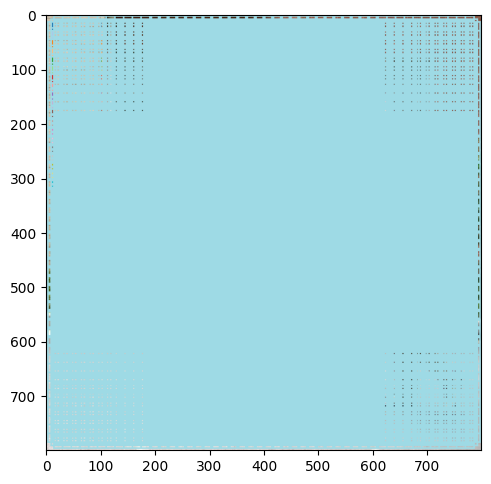

In [21]:
torch_bboxes = tv_tensors.BoundingBoxes(
    filtered_bboxes, format="XYXY", canvas_size=v2.functional.get_size(image)
)

colors = [
    mcolors.rgb2hex(plt.get_cmap("tab20")(i))
    for i in range(len(filtered_bboxes))
]
font = "/usr/share/fonts/truetype/ubuntu/UbuntuMono-R.ttf"
bbox_image = draw_bounding_boxes(
    image,
    torch_bboxes,
    font=font,
    width=3,
    fill=False,
    font_size=30,
    colors=colors,
)
iv.plot(bbox_image, subplots_kwargs={"figsize": (5, 5)})

### NOTE


- Once we have generated all the anchor boxes, we need to look at the objects inside the image and assign them to the specific anchor boxes which contain them. Faster-R-CNN has some guidelines to assign labels to the anchor boxes
- We assign a positive label to 2 kind of anchor boxes:
  - All the anchor boxes with the highest IoU overlap with gt-box or
  - The anchor box that has an IoU overlap higher than 0.7 with gt-box
    - Basically finding out which gt has highest overlap with an anchor box
    - Later verifying if that IoU is greater than 0.7 or not
  - With these conditions a single gt may assign positive labels to multiple anchor boxes
- We assign a negative label to a anchor box if it's IoU ratio is lower than 0.3 for all gt-boxes
- **Anchor boxes which are neither positive nor negative do not contribute to the training objective**


In [22]:
# Create label for the valid anchor boxes and fill it with -1
label = np.empty((len(filtered_bboxes),), dtype=np.int8)
label.fill(-1)
print(label.shape)
print(filtered_bboxes.shape)

(8940,)
(8940, 4)


In [23]:
filtered_bboxes_tensor = tv_tensors.BoundingBoxes(
    filtered_bboxes, format="XYXY", canvas_size=v2.functional.get_size(image)
)

In [24]:
# for each valid anchor box calculate the IoU with each gt object.
# Since we have 8940 anchor boxes and 2 gt_objects, we should get an array of
# (8940,2) where each collumn depicts whether anchor bbox is +ve or not

# Complete box iou function takes cross product kind of calculation, while the
# simple box_iou takes dot product kind of calculation, calculating iou's only in between corresponding bboxes in 2 arrays
valid_bbox_ious = tv.ops.complete_box_iou(
    filtered_bboxes_tensor,
    bboxes,
)
print(valid_bbox_ious.shape)

torch.Size([8940, 2])


- Now from the IoU's we have to make a selection according to above mentioned points to the labels:
  - Assign positive label if:
    - Find highest IoU value with each gt, and all the anchor bboxes that yields the highest IoU
      - Here it might happen that more than 2 anchors come for 1 gt, and this is fine,
        as this is highest IoU value from perspective of GT
    - Find each anchor boxes, highest IoU giving GT
      - From these indexes select only the one's having IoU > 0.7 threshold
      - The reason for doing this is to minimize the search space.
      - If we directly use threshold, then it can happen that more than one anchor box is available to 1 gt,
        and we would want to avoid this scenario from perspective of Anchor Box
  - Assign negative label if:
    - IoU is lower than 0.3 for **all gt's**
  - If not positive, nor -ve then ignore


In [25]:
# Good example to explain the next bit
# This code will find, at what positions in a, do we find 1
# We find it at (0,0) in first array, (1,0) and (2,1) in 3rd array
a = np.array([[1, 2], [1, 4], [3, 1]])
b = np.array([1])
c = np.where(a == b)
print(c)

(array([0, 1, 2]), array([0, 0, 1]))


In [26]:
ls = np.array([1, 5, 6, 6, 4])
ls.argmax()  # Only gives first occurence and not all the indices

2

#### Case-I: Finding All Anchors Having Highest Intersection with GT


In [27]:
# NOTE: Simply doing argmax and collecting that anchor might not be enough because argmax only gives first occurence of highest element as in above example

# index of anchors having highest iou's with gt's
gt_argmax_ious = valid_bbox_ious.argmax(axis=0)
# iou values at these argmax index
gt_max_ious = valid_bbox_ious[
    gt_argmax_ious, [0, 1]
]  # Select 0th column in first row and 1st column in the second row


# get all the indexes of anchors having these high value of iou's with gt
gt_max_iou_anchors_index = np.where(valid_bbox_ious == gt_max_ious)[0]
# (array([3331, 8535]), array([0, 1]))
# This means element at (3331,0) and (8535,1) correspond to the gt_max_ious
# If there could have been more anchors yielding the same highest gt_max_iou
# values, then we could have more than 2 indices, i.e. more than 2 anchors

print(gt_argmax_ious, gt_max_ious, gt_max_iou_anchors_index)

tensor([3331, 8535]) tensor([0.8677, 0.7149], dtype=torch.float64) [3331 8535]


#### Case-II: Finding GT for which Anchor yields a high value


In [28]:
# Index of Gt's for which an anchor gives high IoU as compare to other Gt's
anchor_argmax_ious = valid_bbox_ious.argmax(axis=1)

# Getting the max iou values
anchor_max_ious = valid_bbox_ious[
    np.arange(len(filtered_bboxes)), anchor_argmax_ious
]


print(anchor_argmax_ious.shape, anchor_max_ious.shape)

torch.Size([8940]) torch.Size([8940])


### Filling of Labels


In [29]:
pos_iou_threshold = 0.7
neg_iou_threshold = 0.3

- Assign negative label (0) to all the anchor boxes which have max_iou less than negative threshold


In [30]:
# NOTE: Finding the max of 2 anchors, decreased the search space as now we only need to compare the max anchors
label[anchor_max_ious < neg_iou_threshold] = 0

- Assign positive label (1) to all the anchor boxes which have Highest IoU overlap with gt-bbox
- Assign positive label (1) to all the anchor boxes which have max_iou greater than pos_threshold


In [31]:
label[gt_argmax_ious] = 1
label[anchor_max_ious >= pos_iou_threshold] = 1

## 5. Generating Target Anchor Bboxes for Training, which are near to the GT's and chosen from all Anchor Bboxes


- Once we have labels, we only use some of them for training RPN
- Each mini-batch arises from a single image that contains many positive and negitive example anchors, but this will bias towards negitive samples as they dominate
- Instead, we randomly sample 256 anchors in an image to compute the loss function of a mini-batch, where the sampled positive and negative anchors have a ratio of up to 1:1
- If there are fewer than 128 positive samples in an image, we pad the mini-batch with negative ones


In [32]:
pos_ratio = 0.5
n_sample = 256


# Total Positive Samples
n_pos = pos_ratio * n_sample

- Randomly sample n_pos samples from the positive labels and ignore (-1) the remaining ones.
- In some cass when n_pos are lesss than expected then we will randomly sample (n_sample - n_pos) i.e. more negative samples (0) and assign ignore label to the remaining anchor boxes


In [33]:
np.sum(label == 1)

23

In [34]:
n_neg = n_sample * np.sum(label == 1)
n_neg

5888

In [35]:
# Positive Samples
pos_index = np.where(label == 1)[0]
if len(pos_index) > n_pos:
    # If more positive sample than expected, then randomly sample indexes to not use in training
    disable_index = np.random.choice(
        pos_index, size=(len(pos_index) - n_pos), replace=False
    )
    label[disable_index] = -1

# Negative Samples
n_neg = n_sample * np.sum(label == 1)
neg_index = np.where(label == 0)[0]
if len(neg_index) > n_neg:
    disable_index = np.random.choice(
        neg_index, size=(len(neg_index) - n_neg), replace=False
    )
    label[disable_index] = -1

### Assigning Locations (GTs) to Anchor Boxes, and these will be our Target Boxes to train with

- Basically we will select gt's for an anchor that has high iou with anchor.
  - By selecting it means to find the locations of gt wrt the anchor box location
  - Like only taking the object that will fit into the anchor box or something like this
- NOTE: We will assign anchor locs to all valid anchor boxes, irrespective of it's label. Later when we calculate losses, we can remove the irrelevant anchor boxes
- To do all the stuff Faster-RCNN uses the following parameters:
  - $t_{x} = (x - x_{a})/w_{a}$
  - $t_{y} = (y - y_{a})/h_{a}$
  - $t_{w} = log(w/ w_a)$
  - $t_{h} = log(h/ h_a)$
  - $x,y,w,h$ are the gt box center coordinates, width and height
  - $x_a, y_a, w_a, h_a$ are the anchor box center coordinates, it's width and height


In [36]:
# For each anchor box, first we select the gt that has max iou with the anchor box
# We will have 8940 elements itself, as for each filtered bbox, we just find a gt-bbox
max_iou_bbox = filtered_bboxes[anchor_argmax_ious]
print(max_iou_bbox.shape)
print(max_iou_bbox)

(8940, 4)
[[ 10.745166    13.49033201 101.254834   194.50966799]
 [ 10.745166    13.49033201 101.254834   194.50966799]
 [ 10.745166    13.49033201 101.254834   194.50966799]
 ...
 [ 10.745166    29.49033201 101.254834   210.50966799]
 [ 10.745166    29.49033201 101.254834   210.50966799]
 [ 10.745166    29.49033201 101.254834   210.50966799]]


In [37]:
# NOTE; Before we proceed further we need to convert xyxy bbox format of our anchor boxes and gt boxes to xywh.
height = filtered_bboxes[:, 2] - filtered_bboxes[:, 0]
width = filtered_bboxes[:, 3] - filtered_bboxes[:, 1]
ctr_y = filtered_bboxes[:, 0] + 0.5 * height
ctr_x = filtered_bboxes[:, 1] + 0.5 * width


base_height = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
base_width = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_ctr_y = max_iou_bbox[:, 0] + 0.5 * base_height
base_ctr_x = max_iou_bbox[:, 1] + 0.5 * base_width

In [38]:
# Getting the Anchor Locations with above formulaes
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)
dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)
anchor_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(anchor_locs)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -8.83883476e-02  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.76776695e-01  0.00000000e+00  0.00000000e+00]
 ...
 [-7.60139790e+00 -3.00520382e+00 -6.66133815e-16 -6.66133815e-16]
 [-7.60139790e+00 -3.09359217e+00 -6.66133815e-16 -6.66133815e-16]
 [-7.60139790e+00 -3.18198052e+00 -6.66133815e-16 -6.66133815e-16]]


### Mapping the locations and labels to the whole Anchors (22500) and Labels


In [39]:
# Final Labels
anchor_labels = np.empty((len(anchor_bboxes),), dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_inside] = label

In [40]:
# Final Anchors
anchor_locations = np.empty(
    (len(anchor_bboxes),) + anchor_bboxes.shape[1:], dtype=anchor_locs.dtype
)
anchor_locations.fill(0)
anchor_locations[index_inside, :] = anchor_locs

In [41]:
print(anchor_labels.shape, anchor_locations.shape)

(22500,) (22500, 4)


### **These labels and Anchors (with valid labels) will be used as targets to the RPN network.**


## 6. Region Proposal Network


<img src="https://miro.medium.com/v2/resize:fit:4800/format:webp/1*rQ99lLIs7xTAjTaKHHNatA.png" alt="Image" style="height:300px; width:600px; align:center">


- Prior to this work, region proposals for a network were generated using selective search, CPMC, MCG, Edgeboxes etc. Faster_R-CNN is the first work to demonstrate generating region proposals using deep learning.
- The network contains a convolution module, on top of which there will be one regression layer, **which predicts the location of the box inside the anchor**
- To generate region proposals, we slide a small network over the feature map op.
  - This small network takes as input an nxn spatial window of the ip feature map
  - Each sliding window is mapped to a lower dimensional feature (Basically conv operation)
  - The op of the small conv network is fed to 2 FC layers:
    - A box regression layer
    - A box classification layer


In [42]:
# We use n = 3, as Faster-RCNN paper. We can any other value of n as well.
mid_channels = 512
in_channels = 512  # NOTE: Dependent on the feature map given by the backbone, for VGG16 it's 512
n_anchor_boxes = 9  # Number of anchor boxes at each anchor point

In [43]:
conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1).to(device)
reg_layer = nn.Conv2d(mid_channels, n_anchor_boxes * 4, 1, 1, 0).to(device)
cls_layer = nn.Conv2d(mid_channels, n_anchor_boxes * 2, 1, 1, 0).to(
    device
)  ## I will be going to use softmax here. you can equally use sigmoid if u replace 2 with 1.


# Initial Initialization as per the paper
# conv sliding layer
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()
# Regression layer
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()
# classification layer
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()


# Sending the ops from feature extraction state to this network to predict location of objects wrt anchor and the objectness score associated with it
x = conv1(feature_map)  # Feature Map Obtained in Sec 3
pred_anchor_locs = reg_layer(x)
pred_cls_scores = cls_layer(x)
print(pred_cls_scores.shape, pred_anchor_locs.shape)

torch.Size([1, 18, 50, 50]) torch.Size([1, 36, 50, 50])


#### Reformatting the ops


In [44]:
pred_anchor_locs = (
    pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
)
print(pred_anchor_locs.shape)
# Out: torch.Size([1, 22500, 4])
pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
print(pred_cls_scores.shape)
# Out torch.Size([1, 50, 50, 18])
objectness_score = (
    pred_cls_scores.view(1, 50, 50, 9, 2)[:, :, :, :, 1]
    .contiguous()
    .view(1, -1)
)
print(objectness_score.shape)
# Out torch.Size([1, 22500])
pred_cls_scores = pred_cls_scores.view(1, -1, 2)
print(pred_cls_scores.shape)
# Out torch.size([1, 22500, 2])

torch.Size([1, 22500, 4])
torch.Size([1, 50, 50, 18])
torch.Size([1, 22500])
torch.Size([1, 22500, 2])


- pred_cls_scores and pred_anchor_locs are the output the RPN network and the losses to updates the weights
- pred_cls_scores and objectness_scores are used as inputs to the proposal layer, which generate a set of proposal which are further used by RoI network. We will see this in the next section.


In [45]:
print(pred_anchor_locs.shape)
print(pred_cls_scores.shape)
print(anchor_locations.shape)
print(anchor_labels.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 22500, 2])
(22500, 4)
(22500,)


In [46]:
rpn_loc = pred_anchor_locs[0]
rpn_score = pred_cls_scores[0]

gt_rpn_loc = torch.from_numpy(anchor_locations)
gt_rpn_score = torch.from_numpy(anchor_labels)

print(rpn_loc.shape, rpn_score.shape, gt_rpn_loc.shape, gt_rpn_score.shape)

torch.Size([22500, 4]) torch.Size([22500, 2]) torch.Size([22500, 4]) torch.Size([22500])


In [47]:
# For classification we use cross-entropy loss
rpn_cls_loss = nn.functional.cross_entropy(
    rpn_score, gt_rpn_score.long().to(device), ignore_index=-1
)
print(rpn_cls_loss)

tensor(1.1074, device='cuda:0', grad_fn=<NllLossBackward0>)


In [48]:
# For Regression we use smooth L1 loss as defined in the Fast RCNN paper
pos = gt_rpn_score > 0
mask = pos.unsqueeze(1).expand_as(rpn_loc)
print(mask.shape)

# take those bounding boxes which have positve labels
mask_loc_preds = rpn_loc[mask].view(-1, 4)
mask_loc_targets = gt_rpn_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
rpn_loc_loss = ((x < 1).float() * 0.5 * x**2) + ((x >= 1).float() * (x - 0.5))
print(rpn_loc_loss.sum())

torch.Size([22500, 4])
torch.Size([23, 4]) torch.Size([23, 4])
tensor(123.7273, dtype=torch.float64, grad_fn=<SumBackward0>)


In [49]:
# Combining both the rpn_cls_loss and rpn_reg_loss
rpn_lambda = 10.0
N_reg = (gt_rpn_score > 0).float().sum()
rpn_loc_loss = rpn_loc_loss.sum() / N_reg
rpn_loss = rpn_cls_loss + (rpn_lambda * rpn_loc_loss)
print(rpn_loss)

tensor(54.9019, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


## 7. Generating Proposals from RPN to feed Fast R-CNN network


- The proposal function will take the following parameters
  - training_mode or testing_mode
  - nms_thresh
  - n_train_pre_nms: Number of bboxes before nms during training
  - n_train_post_nms: Number of bboxes after nms during training
  - n_test_pre_nms: Number of bboxes before nms during testing
  - n_test_post_nms: Number of bboxes after nms during testing
  - min_size: Minimum height of the object required to create a proposal


- The Faster R_CNN says, RPN proposals highly overlap with each other.
- To reduced redundancy, we adopt non-maximum supression (NMS) on the proposal regions based on their cls scores.
- We fix the IoU threshold for NMS at 0.7, which leaves us about 2000 proposal regions per image.
- After an ablation study, the authors show that NMS does not harm the ultimate detection accuracy, but substantially reduces the number of proposals.
- After NMS, we use the top-N ranked proposal regions for detection. In the following we training Fast R-CNN using 2000 RPN proposals.
- During testing they evaluate only 300 proposals, they have tested this with various numbers and obtained this.


In [50]:
nms_thresh = 0.7
n_train_pre_nms = 12000
n_train_post_nms = 2000
n_test_pre_nms = 6000
n_test_post_nms = 300
min_size = 16

- To generate region proposals to the network following steps will be followed
  - Convert the loc (anchor location) predictions from the rpn network to bbox [y1,x1,y2,x2]
  - Clip the predicted boxes to the image
  - Remove predicted boxes with either height or width < threshold (minsize)
  - Sort all (proposal, score) pairs by score from highest to lowest
  - Take top pre_nms_topN (e.g. 12000 while training and 300 while testing)
  - Apply nms threshold > 0.7
  - Take top pos_nms_topN (eg. 2000 while training and 300 while testing)


### Converting the Anchor Location Predictions to BBox


- This operation is reverse operation of what we did while assigning gt to anchor boxes.
- This operation decodes predictions by unparameterizing them and offseting to image.
  - #ctr is for center
  - $x = (w_{a} * ctr_{xp}) + ctr_{xa}$
  - y = $(h_{a} * ctr_{xp}) + ctr_{xa}$
  - $h = np.exp(h_{p}) * h_{a}$
  - $w = np.exp(w_{p}) * w_{a}$


#### Convert anchors bbox format from y1, x1, y2, x2 to ctr_x, ctr_y, h,2


In [60]:
anc_height = anchor_bboxes[:, 2] - anchor_bboxes[:, 0]
anc_width = anchor_bboxes[:, 3] - anchor_bboxes[:, 1]
anc_ctr_y = anchor_bboxes[:, 0] + 0.5 * anc_height
anc_ctr_x = anchor_bboxes[:, 1] + 0.5 * anc_width
print(anc_ctr_x.shape, anc_ctr_y.shape)

(22500,) (22500,)


#### Convert prediction locations using above formulas, before doing this don't forget to get data in np array


In [61]:
pred_anchor_locs_numpy = pred_anchor_locs[0].cpu().data.numpy()
objectness_score_numpy = objectness_score[0].cpu().data.numpy()
dy = pred_anchor_locs_numpy[:, 0::4]
dx = pred_anchor_locs_numpy[:, 1::4]
dh = pred_anchor_locs_numpy[:, 2::4]
dw = pred_anchor_locs_numpy[:, 3::4]
ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
h = np.exp(dh) * anc_height[:, np.newaxis]
w = np.exp(dw) * anc_width[:, np.newaxis]

print(dy.shape, w.shape)

(22500, 1) (22500, 1)


#### Convert [ctr_x, ctr_y, h, w] to [y1, x1, y2, x2]


In [62]:
roi = np.zeros(pred_anchor_locs_numpy.shape, dtype=anchor_locs.dtype)
roi[:, 0::4] = ctr_y - 0.5 * h
roi[:, 1::4] = ctr_x - 0.5 * w
roi[:, 2::4] = ctr_y + 0.5 * h
roi[:, 3::4] = ctr_x + 0.5 * w
print(roi.shape)

(22500, 4)


### CLIP the predicted boxes to the image


In [54]:
img_size = (800, 800)  # Image size
roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, img_size[0])
roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, img_size[1])
print(roi.shape, np.max(roi), np.min(roi))

(22500, 4) 800.0 0.0


In [55]:
import numpy as np

# Create a numpy array
arr = np.array([1, 2, 3, 4, 5])

# Clip the values of the array between a minimum and maximum value
clipped_arr = np.clip(arr, 2, 4)

print(clipped_arr)

[2 2 3 4 4]


### Remove predicted boxes with either height or width < threshold


In [56]:
hs = roi[:, 2] - roi[:, 0]
ws = roi[:, 3] - roi[:, 1]
keep = np.where((hs >= min_size) & (ws >= min_size))[0]
roi = roi[keep, :]
score = objectness_score_numpy[keep]
print(keep.shape, roi.shape, score.shape)
# Out:
##(22500, ) all the boxes have minimum size of 16

(12033,) (12033, 4) (12033,)


### Sort all (proposal, score) pairs by the score from highest to lowest


In [57]:
order = score.ravel().argsort()[::-1]
print(order.shape)

(12033,)


### Take the top pre_nms_topN


In [58]:
order = order[:n_train_pre_nms]
roi = roi[order, :]
print(roi.shape)
print(roi)

(12000, 4)
[[  0.         624.1067565  800.         800.        ]
 [  0.           0.         800.         800.        ]
 [382.46801266 519.56056573 646.43400811 800.        ]
 ...
 [745.8482864  346.96443972 800.         363.98348011]
 [558.98120689 631.88348389 614.71788979 800.        ]
 [  0.          31.59808064  25.44685364  60.61041546]]


### Applying NMS

- NMS is the process in which we remove/merge extremely highly overlapping bounding boxes. In this process the goal is to retain the bboxes, which are unique and doesn't overlap much.
- The threshold is kept at 0.7, and it means the minimum overlapping area required to merge overlapping bboxes


In [63]:
y1 = roi[:, 0]
x1 = roi[:, 1]
y2 = roi[:, 2]
x2 = roi[:, 3]

areas = (x2 - x1 + 1) * (y2 - y1 + 1)
order = order.argsort()[::-1]
keep = []
while order.size > 0:
    i = order[0]  # take the 1st elementt in order and append to keep
    keep.append(i)
    xx1 = np.maximum(x1[i], x1[order[1:]])
    yy1 = np.maximum(y1[i], y1[order[1:]])
    xx2 = np.minimum(x2[i], x2[order[1:]])
    yy2 = np.minimum(y2[i], y2[order[1:]])
    w = np.maximum(0.0, xx2 - xx1 + 1)
    h = np.maximum(0.0, yy2 - yy1 + 1)
    inter = w * h
    ovr = inter / (areas[i] + areas[order[1:]] - inter)
    inds = np.where(ovr <= nms_thresh)[0]
    order = order[inds + 1]

keep = keep[:n_train_post_nms]  # while training/testing , use accordingly
roi = roi[keep]  # the final region proposals
print(len(keep), roi.shape)

2000 (2000, 4)


## 8. Generating Proposal Targets


#### NOTE

- The final region proposals were obtained.
  - These will be used as the ip to the Fast-RCNN object which finally tries to predict the object locations (with respect to the proposesd box)
  - Also it tries to predict the class of the object (classification of each proposal)
- Before feeding the proposals to the Fast-RCNN:
  - We need to first create targets for these proposals for training the network
- Once we have both targets and proposals:
  - We pass proposals to the network
  - Obtain the predicted Ops
  - Determine the losses


- The Fast R-CNN network takes the region proposals (obtained from proposal layer in previous section), ground truth boxes and their respective labels as inputs.
- It will take the following parameters:
  - n_sample: Number of samples to sample from roi, The default value is 128.
  - pos_ratio: the number of positive examples out of the n_samples. The default values is 0.25.
  - pos_iou_thesh: The minimum overlap of region proposal with any groundtruth object to consider it as positive label.
  - [neg_iou_threshold_lo, neg_iou_threshold_hi] : [0.0, 0.5], The overlap value bounding required to consider a region proposal as negitive [background object].


In [64]:
n_sample = 128
pos_ratio = 0.25
pos_iou_thresh = 0.5
neg_iou_thresh_hi = 0.5
neg_iou_thresh_lo = 0.0

- Following steps are used to generate the proposal targets

  - For each roi, find the IoU with all other gt object ([N,n])
    - N: Number of Region Proposals
    - n: Number of gt boxes
  - Find which gt object has highest iou with the roi [N]
    - These gt's labels will be the labels for each and every region proposal
  - If the highest IoU is greater than pos_iou_thresh, then we assign the label of gt
    - Pos_Samples_Collection:
      - We randomly sample [n_sample x pos_ratio] region proposals and consider only these as positive labels
  - If the IoU is between [0.1, 0.5], we assign a negative label(0) to the region proposal

    - Neg_Samples_Collection:
      - We randomly sample [128 - number of pos region proposals on this image] and assign 0 to these region proposals

  - We collect the pos samples and neg_samples and remove all other region proposals
  - Lastly we convert the locations of gt objects for each region proposal to the required format (As required by Fast R-CNN)
  - Output labels and locations for the samples ROIs (i.e. the targets)


In [66]:
roi_tensor = tv_tensors.BoundingBoxes(
    roi, format="XYXY", canvas_size=v2.functional.get_size(image)
)

In [69]:
# Finding the IoU of gt_object with region proposals
target_region_proposal_ious = valid_bbox_ious = tv.ops.complete_box_iou(
    roi_tensor,
    bboxes,
)
print(target_region_proposal_ious.shape)

torch.Size([2000, 2])


In [90]:
# Find out which ground truth has high IoU for each region proposal, Also find the maximum IoU
gt_assignment = target_region_proposal_ious.argmax(axis=1)
max_iou = target_region_proposal_ious.max(axis=1)
print(gt_assignment)
print(max_iou)

# Assign the labels to each proposal
labels = np.array(labels)
gt_roi_label = labels[gt_assignment]
print(gt_roi_label)

# Note: Incase if u have not taken the background object as 0, add +1 to all the labels.

tensor([0, 1, 0,  ..., 0, 1, 0])
torch.return_types.max(
values=tensor([-0.1488, -0.6121, -0.4812,  ..., -0.2853, -0.1306, -0.4989],
       dtype=torch.float64),
indices=tensor([0, 1, 0,  ..., 0, 1, 0]))
['1' '1' '1' ... '1' '1' '1']


In [93]:
# Select the foreground rois as per the pos_iou_thesh and
# n_sample x pos_ratio (128 x 0.25 = 32) foreground samples.
pos_roi_per_image = 32
pos_index = np.where(max_iou.values >= pos_iou_thresh)[0]
pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))
if pos_index.size > 0:
    pos_index = np.random.choice(
        pos_index, size=pos_roi_per_this_image, replace=False
    )
print(pos_roi_per_this_image)
print(pos_index)

# Similarly we do for negitive (background) region proposals
neg_index = np.where(
    (max_iou.values < neg_iou_thresh_hi)
    & (max_iou.values >= neg_iou_thresh_lo)
)[0]
neg_roi_per_this_image = n_sample - pos_roi_per_this_image
neg_roi_per_this_image = int(min(neg_roi_per_this_image, neg_index.size))
if neg_index.size > 0:
    neg_index = np.random.choice(
        neg_index, size=neg_roi_per_this_image, replace=False
    )
print(neg_roi_per_this_image)
print(neg_index)

3
[ 707 1029  523]
125
[ 551 1575 1131  613 1376  773  117 1972 1396 1934  303 1979   71 1164
 1515 1784  740 1115 1932  727 1226 1040 1561 1418 1875  593  845 1338
  354  284  512  846  306 1094 1122  808 1374  728 1766  572  385 1682
 1709 1669 1286  399  147  791  912 1717 1676   99  713  920  268 1174
  999 1921 1526 1254  695  663  960 1858  462  787  319  416  631 1918
 1818  542 1219  647 1152 1047 1665   50  855 1352  883 1104 1551  545
  954 1684 1079 1341 1325  516 1630 1452 1017  764 1287 1347 1244 1817
  318  146  703  233 1879 1660 1020 1705  573  228 1247  749  962  390
  806 1518 1455  166 1126  565  199 1752  624 1034 1422  294  828]


In [102]:
roi[pos_index[2]].astype(int)

array([238, 222, 409, 547])

##### Displaying +ve and -ve ROI samples


In [129]:
roi_imgs = []
roi_bboxes = []
pos_labels = []
for i in range(pos_roi_per_this_image):
    roi_bbox = roi[pos_index[i]].astype(int)
    roi_bboxes.append(roi_bbox)
    pos_labels.append(gt_roi_label[pos_index[i]].astype(str))

torch_bboxes = tv_tensors.BoundingBoxes(
    roi_bboxes, format="XYXY", canvas_size=v2.functional.get_size(image)
)
colors = [
    mcolors.rgb2hex(plt.get_cmap("tab20")(i)) for i in range(len(torch_bboxes))
]
font = "/usr/share/fonts/truetype/ubuntu/UbuntuMono-R.ttf"
positive_samples_bbox_img = draw_bounding_boxes(
    image,
    torch_bboxes,
    font=font,
    width=3,
    fill=False,
    font_size=30,
    labels=pos_labels,
    colors=colors,
)

roi_imgs = []
roi_bboxes = []
neg_label = []
for i in range(neg_roi_per_this_image):
    roi_bbox = roi[neg_index[i]].astype(int)
    roi_bboxes.append(roi_bbox)
    neg_label.append(gt_roi_label[neg_index[i]].astype(str))
torch_bboxes = tv_tensors.BoundingBoxes(
    roi_bboxes, format="XYXY", canvas_size=v2.functional.get_size(image)
)
colors = [
    mcolors.rgb2hex(plt.get_cmap("tab20")(i)) for i in range(len(torch_bboxes))
]
font = "/usr/share/fonts/truetype/ubuntu/UbuntuMono-R.ttf"
negative_samples_bbox_img = draw_bounding_boxes(
    image,
    torch_bboxes,
    font=font,
    width=3,
    fill=False,
    font_size=30,
    labels=neg_label,
    colors=colors,
)

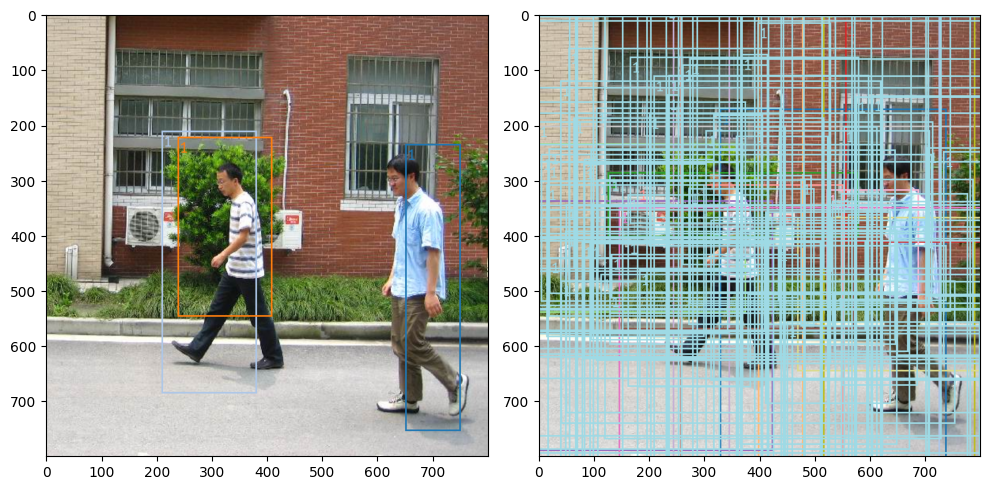

In [130]:
iv.plot(
    [positive_samples_bbox_img, negative_samples_bbox_img],
    subplots_kwargs={"figsize": (10, 10)},
)
# The negative indexes are 1, but we will set them next

In [132]:
# Now we gather positive sample index and negative sample index, their respective labels and region proposals
keep_index = np.append(pos_index, neg_index)
gt_roi_labels = gt_roi_label[keep_index]
gt_roi_labels[pos_roi_per_this_image:] = 0  # negative labels --> 0
sample_roi = roi[keep_index]
print(sample_roi.shape)


# Pick the gt objects for these sample_roi and later parameterize as we have done while assigning locations to anchor boxes in section 5.
bbox_for_sampled_roi = bboxes[gt_assignment[keep_index]]
print(bbox_for_sampled_roi.shape)

height = sample_roi[:, 2] - sample_roi[:, 0]
width = sample_roi[:, 3] - sample_roi[:, 1]
ctr_y = sample_roi[:, 0] + 0.5 * height
ctr_x = sample_roi[:, 1] + 0.5 * width

base_height = bbox_for_sampled_roi[:, 2] - bbox_for_sampled_roi[:, 0]
base_width = bbox_for_sampled_roi[:, 3] - bbox_for_sampled_roi[:, 1]
base_ctr_y = bbox_for_sampled_roi[:, 0] + 0.5 * base_height
base_ctr_x = bbox_for_sampled_roi[:, 1] + 0.5 * base_width

(128, 4)
torch.Size([128, 4])


#### Target Formulation

- $t_{x} = (x - x_{a})/w_{a}$
- $t_{y} = (y - y_{a})/h_{a}$
- $t_{w} = log(w/ w_a)$
- $t_{h} = log(h/ h_a)$


In [133]:
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)

gt_roi_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(gt_roi_locs.shape)

(128, 4)


- So now we have gt_roi_locs, and gt_rooi_labels for the sampled rois.
- We now need to design the Fast RCNN network and predict the locs and labels


## 9. Fast R-CNN
